# [A model to predict the delta run expectancy of a pitch not swung at]

In [6]:
import pandas as pd
import time as time
import numpy as np

from scipy.stats import zscore

import pybaseball
from pybaseball import statcast
from pybaseball import chadwick_register

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import hyperopt.hp as hp
from hyperopt import fmin, tpe, Trials, STATUS_OK

import joblib


In [7]:
path = '/Users/aidanbeilke/Desktop/Baseball Projects'

data = pd.read_csv(f"{path}/attack_df.csv")

In [8]:
data.shape

(713552, 97)

In [9]:
data = data.drop(columns = ['Unnamed: 0'])

In [10]:
data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,attack_zone,swing
0,FF,2023-09-30,96.1,-2.08,5.57,"Smith, Drew",664761,622098,field_out,hit_into_play,...,11,Standard,Standard,212.0,0.0,-0.074,NaN,NaN,waste,Y
1,FF,2023-09-30,96.5,-1.94,5.59,"Smith, Drew",664761,622098,NaN,foul,...,11,Standard,Standard,209.0,0.0,0.000,NaN,NaN,heart,Y
2,SL,2023-09-30,86.6,-1.91,5.54,"Smith, Drew",664761,622098,NaN,ball,...,11,Standard,Standard,114.0,0.0,0.009,NaN,NaN,chase,N
3,SL,2023-09-30,87.1,-2.01,5.55,"Smith, Drew",664761,622098,NaN,swinging_strike,...,11,Standard,Standard,108.0,0.0,-0.023,NaN,NaN,chase,Y
4,FF,2023-09-30,95.9,-2.10,5.51,"Smith, Drew",664761,622098,NaN,foul,...,11,Standard,Standard,215.0,0.0,-0.017,NaN,NaN,shadow,Y


### Model Building

In [11]:
cols = ['balls', 'strikes', 'release_speed','release_spin_rate' ,'pitch_type', 'pfx_x', 'pfx_z', 'delta_run_exp', 'plate_x', 'plate_z', 'attack_zone', 'p_throws']

continuous_cols = ['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate']

cat_cols = ['balls', 'strikes', 'pitch_type', 'attack_zone', 'p_throws']

In [12]:
# Takes only

data_ = data[~data['description'].isin(['hit_into_play', 'swinging_strike', 'foul'])]

In [13]:
model_df = data_[cols]

model_df.shape

(387084, 12)

In [14]:
model_df[continuous_cols] = StandardScaler().fit_transform(model_df[continuous_cols])


/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_82044/4067100459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[continuous_cols] = StandardScaler().fit_transform(model_df[continuous_cols])


In [15]:
model_df.shape

(387084, 12)

### Check NA Values

In [16]:
model_df.columns[model_df.isna().any()].tolist()

['release_speed',
 'release_spin_rate',
 'pitch_type',
 'pfx_x',
 'pfx_z',
 'delta_run_exp',
 'plate_x',
 'plate_z']

In [17]:
def calculate_null_percentage(df):

    null_pct = df.isnull().mean()
    return null_pct

null_pct = calculate_null_percentage(model_df)
null_pct

balls                0.000000
strikes              0.000000
release_speed        0.000377
release_spin_rate    0.006022
pitch_type           0.000369
pfx_x                0.000377
pfx_z                0.000377
delta_run_exp        0.000134
plate_x              0.000377
plate_z              0.000377
attack_zone          0.000000
p_throws             0.000000
dtype: float64

In [18]:
model_df = model_df.dropna()

In [19]:
cats = ['pitch_type', 'attack_zone', 'p_throws']

for i in cats:
    model_df[i] = model_df[i].astype('category').cat.codes

model_df

,balls,strikes,release_speed,release_spin_rate,pitch_type,pfx_x,pfx_z,delta_run_exp,plate_x,plate_z,attack_zone,p_throws
2,0,2,-0.361818,1.056993,13,0.665269,-0.936702,0.009,1.193390,-0.562704,0,1
7,1,1,-0.442778,-1.043760,0,-1.393044,0.342016,0.053,0.708823,-1.252084,0,1
9,0,0,-1.900046,1.252826,2,1.533098,-1.679183,0.036,-1.360684,2.229723,3,1
14,1,2,-1.236179,-1.426524,0,1.811249,-0.634209,0.029,0.315112,-1.758212,3,0
16,0,1,0.723037,-1.509604,12,1.855753,-0.702958,0.019,-1.128495,0.423372,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
713547,3,1,1.046874,-0.396918,12,-1.749076,-0.152972,-0.079,-1.057829,0.432098,2,1
713548,3,0,0.868764,0.089697,6,-1.292910,0.809504,-0.078,-0.795355,0.589172,2,1
713549,2,0,0.965915,-0.390983,6,-0.758861,0.850753,0.135,1.556815,0.179034,0,1
713550,1,0,1.014490,-0.379115,12,-1.771328,-0.221720,0.064,-1.380874,0.013234,3,1


### Model Selection

In [20]:
X = model_df[continuous_cols + cat_cols]
y = model_df['delta_run_exp']

In [21]:
models = [
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    Ridge(alpha=1)
]

names = [
    'Linear Regression',
    'KNN',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBoost',
    'Ridge'
]

In [58]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [64]:
results = []

for reg, name in zip(models, names):
    start = time.time()
    cv_results = cross_validate(reg, X, y, cv=5, scoring={
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': 'r2',
        'RMSE' : rmse_scorer
    })
    stop_time = time.time()

    print('Time to cross-validate %s = %0.3f min.' % (name, (stop_time - start) / 60))

    results.append({
        'Regressor': name,
        'MSE': -cv_results['test_MSE'].mean(),  
        'MAE': -cv_results['test_MAE'].mean(),
        'R^2 Score': cv_results['test_R2'].mean(),
        'RMSE' : -cv_results['test_RMSE'].mean()
    })
    
    results_df = pd.DataFrame(results)

Time to cross-validate Linear Regression = 0.040 min.
Time to cross-validate KNN = 1.647 min.
Time to cross-validate Decision Tree = 0.521 min.
Time to cross-validate Random Forest = 44.548 min.
Time to cross-validate Gradient Boosting = 4.807 min.
Time to cross-validate XGBoost = 0.107 min.
Time to cross-validate Ridge = 0.012 min.


In [65]:
results_df.head(6)

,Regressor,MSE,MAE,R^2 Score,RMSE
0,Linear Regression,0.008924,0.057769,0.038784,0.094456
1,KNN,0.006381,0.043012,0.312790,0.079868
2,Decision Tree,0.010532,0.051618,-0.135102,0.102625
3,Random Forest,0.005152,0.037050,0.445068,0.071769
4,Gradient Boosting,0.005287,0.037952,0.430691,0.072698
5,XGBoost,0.004888,0.035522,0.473569,0.069904


### XGBoost Model Out-of-Box Params Results

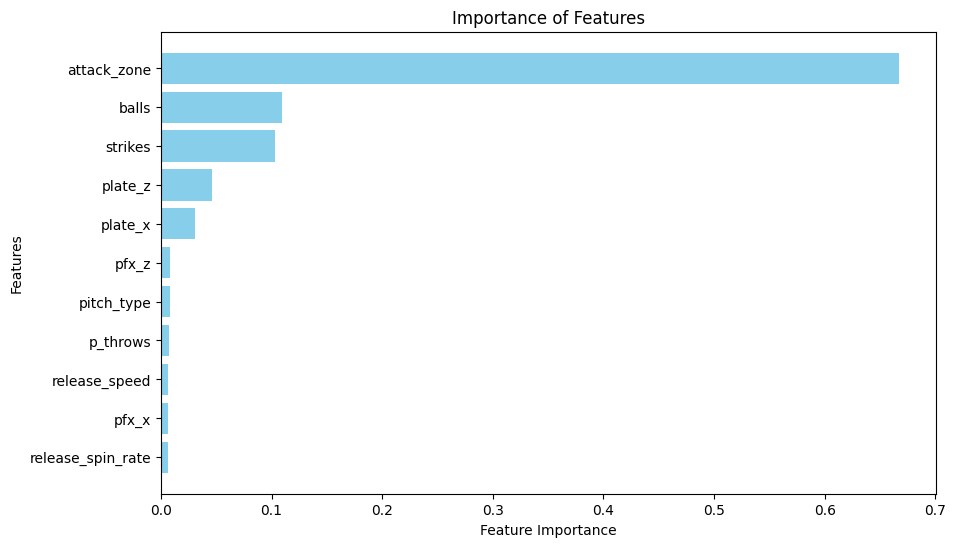

RMSE of the XGBoost on test set: 0.070
R^2 Score of the XGBoost on test set: 0.475
MAE of the XGBoost on test set: 0.036


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
orig_model = XGBRegressor()
orig_model.fit(X_train, y_train)

# Feature Importance
feat_imp = orig_model.feature_importances_
sorted_indices = np.argsort(feat_imp)
predictors = X.columns.tolist()  # ensure X is a DataFrame for this line to work

# Sort feature importances and corresponding feature names
feat_imp_sorted = feat_imp[sorted_indices]
predictors_sorted = [predictors[i] for i in sorted_indices]

# Create a horizontal bar plot for sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(predictors_sorted, feat_imp_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Importance of Features')
plt.show()

# Model Evaluation for Regression
y_pred = orig_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE of the XGBoost on test set: {:.3f}'.format(rmse))
print('R^2 Score of the XGBoost on test set: {:.3f}'.format(r2))
print('MAE of the XGBoost on test set: {:.3f}'.format(mae))

### XGBoost Tuning

In [67]:
# reduce noise

X = model_df[['attack_zone', 'balls', 'strikes', 'plate_x', 'plate_z']]
y = model_df['delta_run_exp']

In [25]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
}

In [88]:
def objective(space):
    clf = XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        min_child_weight=int(space['min_child_weight']),
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        gamma=space['gamma'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        random_state=42
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    return {'loss': rmse, 'status': STATUS_OK}

In [27]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("Best: ", best)

100%|██████████| 100/100 [04:37<00:00,  2.77s/trial, best loss: 0.06926134781092294]
Best:  {'colsample_bytree': 0.8616788678625525, 'gamma': 0.05366493409793818, 'learning_rate': 0.10733791137097379, 'max_depth': 9.0, 'min_child_weight': 1.0, 'n_estimators': 450.0, 'reg_alpha': 0.645286124814892, 'reg_lambda': 0.5566129633506407, 'subsample': 0.6923914774323965}


In [28]:
## Params from best

params = {
    'colsample_bytree': 0.8616788678625525,
    'gamma': 0.05366493409793818,
    'learning_rate' : 0.10733791137097379,
    'max_depth': int(9.0),  
    'min_child_weight': int(1.0),  
    'n_estimators' : int(450.0),
    'reg_alpha': 0.645286124814892,
    'reg_lambda': 0.5566129633506407,
    'subsample' : 0.6923914774323965
}

In [89]:
take_model = XGBRegressor(
    colsample_bytree=params['colsample_bytree'],
    gamma=params['gamma'],
    learning_rate = params['learning_rate'],
    max_depth=params['max_depth'],
    min_child_weight=params['min_child_weight'],
    reg_alpha=params['reg_alpha'],
    reg_lambda=params['reg_lambda'],
    subsample = params['subsample'],
    n_estimators=250,  
    seed=0  
)

# Fit the model with your training data
take_model.fit(X_train, y_train)
y_pred = take_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [91]:
preds = pd.DataFrame(y_pred)

preds.describe()

,0
count,76941.000000
mean,0.015326
std,0.066433
min,-0.336816
25%,-0.033646
50%,0.025675
75%,0.040870
max,0.328164


In [92]:
rmse

0.06926588810946728

In [93]:
y.std()

0.0963553339783335

### Save Model

In [94]:
model_path = '/Users/aidanbeilke/Desktop/Baseball Projects/Swing_Decision/sd_take_model.pkl'

joblib.dump(take_model, model_path)

['/Users/aidanbeilke/Desktop/Baseball Projects/Swing_Decision/sd_take_model.pkl']

### Test on 2024 Data

In [34]:
year = 2024

df = statcast(start_dt= f"{year}-03-30",
                end_dt = f"{year}-05-30")

This is a large query, it may take a moment to complete


/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/62 [00:00<?, ?it/s]/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing

In [95]:
df['attack_zone'] = ""

df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833, 3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.100, 1.100)) & (df['plate_z'].between(1.166, 3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.166, 1.666)) & (df['plate_z'].between(0.5, 4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

df.loc[df['attack_zone'] == "", 'attack_zone'] = 'waste'

In [106]:
# Reduced features to reduce noise 

short_cols = ['attack_zone', 'balls', 'strikes', 'plate_x', 'plate_z']

short_continuous_cols = ['plate_x', 'plate_z']

short_cat_cols = ['balls', 'strikes', 'attack_zone']

In [97]:
df[short_continuous_cols] = StandardScaler().fit_transform(df[short_continuous_cols])


In [98]:
calculate_null_percentage(df[short_cols])

attack_zone    0.0
plate_x        0.0
plate_z        0.0
balls          0.0
strikes        0.0
dtype: float64

In [99]:
cats = ['attack_zone']

for i in cats:
    df[i] = df[i].astype('category').cat.codes

In [100]:
# takes only

df = df[~df['description'].isin(['hit_into_play', 'swinging_strike', 'foul'])]

#### Apply Model

In [101]:
take_model = joblib.load('sd_take_model.pkl')

In [107]:
take_rv = take_model.predict(df[short_cols])

In [108]:
df['pred_run_exp'] = take_rv

final = df[short_continuous_cols + short_cat_cols + ['pred_run_exp', 'batter', 'description']]



#### Find Leaders by Predicted Run Expectancy

In [111]:
leaders = final.groupby(['batter']).agg(
    pitches = ('batter','count'),
    y_pred =  ('pred_run_exp','mean'),
    )

leaders = leaders[leaders['pitches'] >= 200].copy()

In [112]:
leaders = leaders.sort_values(by = 'y_pred', ascending=True).reset_index().copy()

leaders


,batter,pitches,y_pred
0,678882,245,0.027469
1,679032,234,0.029133
2,623912,205,0.030681
3,687952,210,0.030912
4,516782,297,0.031073
...,...,...,...
227,621466,201,0.047855
228,547180,335,0.048588
229,664774,335,0.048706
230,607043,437,0.048722


#### Get Players Names

In [113]:
chadwick_df = chadwick_register()

Gathering player lookup table. This may take a moment.


In [114]:
player_names = chadwick_df[chadwick_df['key_mlbam'].isin(leaders['batter'])]

player_names['full_name'] = player_names['name_first'] + ' ' + player_names['name_last']

names = player_names[['full_name', 'key_mlbam']]

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_82044/1247763656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_names['full_name'] = player_names['name_first'] + ' ' + player_names['name_last']


In [115]:
merged = leaders.merge(names, left_on = 'batter', right_on ='key_mlbam',
                     how = 'inner')

In [116]:
check = merged[['full_name', 'batter', 'y_pred']].sort_values(by = 'y_pred', ascending=False)

check.head()

,full_name,batter,y_pred
231,Kyle Tucker,663656,0.051795
230,Brandon Nimmo,607043,0.048722
229,LaMonte Wade,664774,0.048706
228,Bryce Harper,547180,0.048588
227,DJ Stewart,621466,0.047855


#### Create Take Stat

In [118]:
check['take_rv'] = ((check['y_pred'] - check['y_pred'].mean()) / check['y_pred'].std()) * 15 + 100
check.head(20)

,full_name,batter,y_pred,take_rv
231,Kyle Tucker,663656,0.051795,146.880341
230,Brandon Nimmo,607043,0.048722,135.447021
229,LaMonte Wade,664774,0.048706,135.387512
228,Bryce Harper,547180,0.048588,134.949554
227,DJ Stewart,621466,0.047855,132.222641
226,Joc Pederson,592626,0.046837,128.434494
225,Juan Soto,665742,0.046362,126.666702
224,Aaron Judge,592450,0.045962,125.180428
223,Josh Naylor,647304,0.045908,124.977623
222,Jorge Polanco,593871,0.045828,124.679810


#### Export csv

In [119]:
check.to_csv("take_leaders.csv")